In [2]:
# Load the required Python packages for scRNA-seq preprocessing, analysis, and integration
import scanpy as sc
import scvi
import bbknn
import scib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import anndata as ad
from anndata import AnnData
import seaborn as sns
from scipy.stats import median_abs_deviation
from scipy.sparse import csr_matrix, issparse
import celltypist
import anndata as ad
from celltypist import models
import scib_metrics
from scib_metrics.benchmark import Benchmarker
import scanorama
import pyliger
from harmony import harmonize
import bbknn


sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=150,
    dpi_save=700,
    vector_friendly=False,
    facecolor="white",
    frameon=False,
)

# R interface
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks
import anndata2ri

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [ ]:
%%R
# R packages required for the workflow
library(Seurat)
library(SoupX)
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

# Quality control of the human fetal heart scRNA-seq dataset (GSE241128). We first analyse the 10 post-conception week sample

In [5]:
# Read the data (10x mtx format)
adata = sc.read_10x_mtx(
    path="/mnt/sdb/qdang/singlecell/PMID_37676760/10W", cache=True
)
adata

AnnData object with n_obs × n_vars = 10652 × 36601
    var: 'gene_ids', 'feature_types'

In [6]:
# Defines gene groups of interest for QC
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [7]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 10652 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

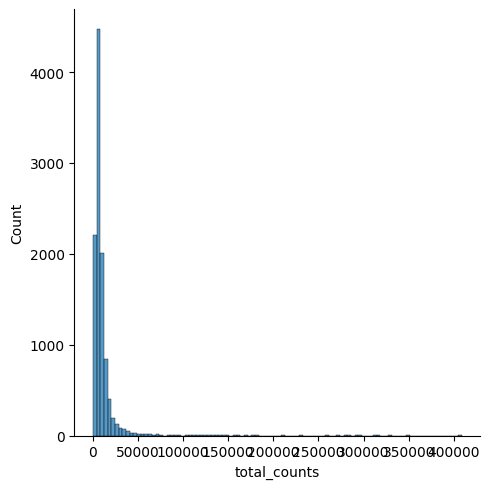

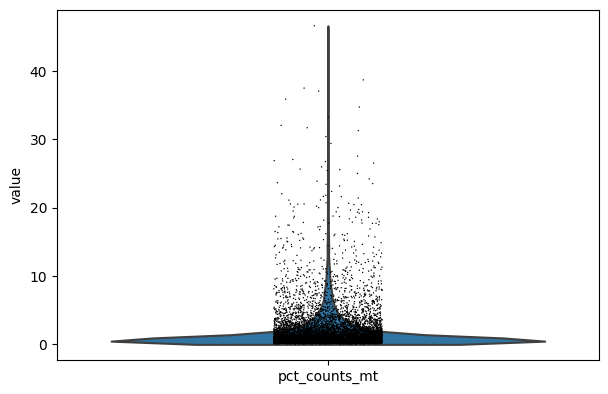

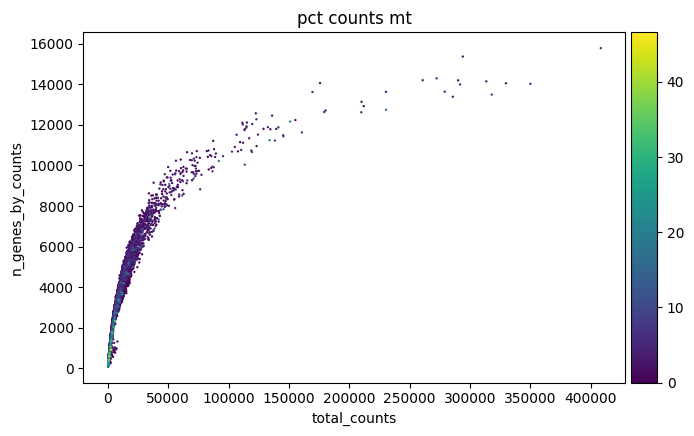

In [8]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [9]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [10]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

False    9917
True      735
Name: outlier, dtype: int64

In [15]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 5)  | (
    adata.obs["pct_counts_mt"] > 15
)
adata.obs.mt_outlier.value_counts()

False    9106
True     1546
Name: mt_outlier, dtype: int64

In [16]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 10652
Number of cells after filtering of low quality cells: 8858


In [29]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

Loading required package: SeuratObject
Loading required package: sp

Attaching package: 'SeuratObject'

The following object is masked from 'package:base':

    intersect

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: 'MatrixGenerics'

The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowC

In [30]:
data_mat = adata.X.T

In [31]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~7087 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1477 cells excluded from training.
iter=1, 1439 cells excluded from training.
iter=2, 1416 cells excluded from training.
Threshold found:0.479
992 (11.2%) doublets called


In [32]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

singlet    7866
doublet     992
Name: scDblFinder_class, dtype: int64

## Analyze the 11 post-conception week sample

In [2]:
adata = sc.read_10x_mtx(
    path="/mnt/sdb/qdang/singlecell/PMID_37676760/11W", cache=True
)
adata

AnnData object with n_obs × n_vars = 15985 × 36601
    var: 'gene_ids', 'feature_types'

In [3]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [4]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 15985 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

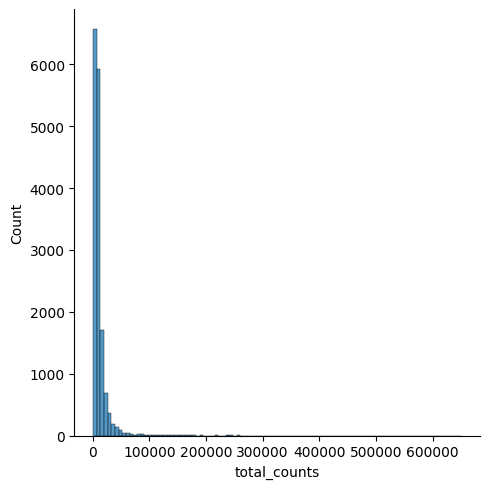

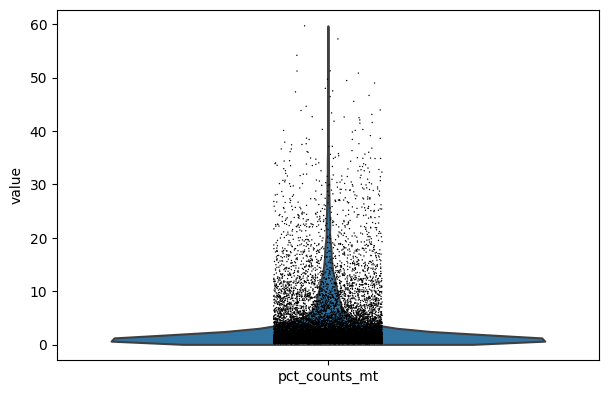

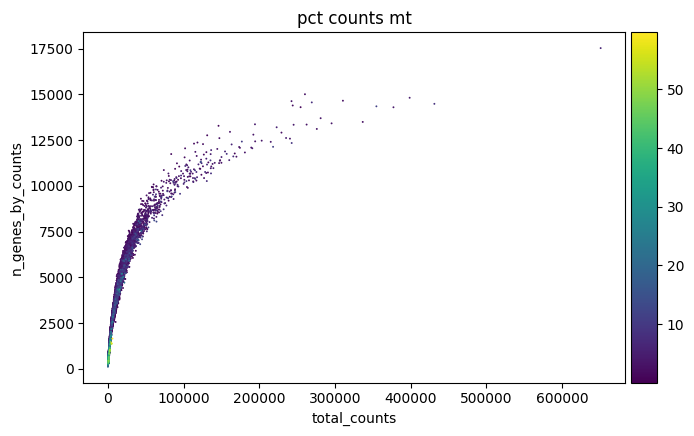

In [5]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [6]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [7]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

False    14127
True      1858
Name: outlier, dtype: int64

In [12]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 5)  | (
    adata.obs["pct_counts_mt"] > 15
)
adata.obs.mt_outlier.value_counts()

False    13390
True      2595
Name: mt_outlier, dtype: int64

In [13]:
# Filter low-quality cells
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 15985
Number of cells after filtering of low quality cells: 13082


In [27]:
data_mat = adata.X.T

In [28]:
# Detect doublets
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~10466 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 2491 cells excluded from training.
iter=1, 2535 cells excluded from training.
iter=2, 2613 cells excluded from training.
Threshold found:0.486
2270 (17.4%) doublets called


In [29]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

singlet    10812
doublet     2270
Name: scDblFinder_class, dtype: int64

## Concatenate

In [3]:
adata1 = sc.read("/mnt/sdb/qdang/singlecell/PMID_37676760/10W/10W_quality_control.h5ad")
adata2 = sc.read("/mnt/sdb/qdang/singlecell/PMID_37676760/11W/11W_quality_control.h5ad")

In [4]:
import anndata as ad
adatas = {"PCW10": adata1, "PCW11": adata2}
adatas = ad.concat(adatas, label="time", join="outer")
adatas.obs_names_make_unique()
adatas

/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 21940 × 24551
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'time'
    layers: 'counts', 'soupX_counts'

In [ ]:
adatas.write("/mnt/sdb/qdang/singlecell/PMID_37676760/concat_raw.h5ad")

# Analyze the scRNA-seq cardiac dataset (GSE213669)

In [83]:
# Load gene expression data as pandas dataframe
df1= pd.read_csv('/mnt/sdb/qdang/singlecell/human/naive/epi_smits/GSM6591812_LUM-AS-001_HLVK5BGX9_S10_R2.TranscriptCounts.tsv', sep='\t', index_col=0)
df2= pd.read_csv('/mnt/sdb/qdang/singlecell/human/naive/epi_smits/GSM6591813_LUM-AS-003_HHKKJBGXB_S3_R2.TranscriptCounts.tsv', sep='\t', index_col=0)
df3= pd.read_csv('/mnt/sdb/qdang/singlecell/human/naive/epi_smits/GSM6591814_LUM-AS-004_HHKKJBGXB_S8_R2.TranscriptCounts.tsv', sep='\t', index_col=0)
df4= pd.read_csv('/mnt/sdb/qdang/singlecell/human/naive/epi_smits/GSM6591816_LUM-AS-006_HHKKJBGXB_S10_R2.TranscriptCounts.tsv', sep='\t', index_col=0)
df5= pd.read_csv('/mnt/sdb/qdang/singlecell/human/naive/epi_smits/GSM6591817_LUM-AS-007_HL32CBGXB_S4_R2.TranscriptCounts.tsv', sep='\t', index_col=0)
df6= pd.read_csv('/mnt/sdb/qdang/singlecell/human/naive/epi_smits/GSM6591818_LUM-AS-008_HL32CBGXB_S5_R2.TranscriptCounts.tsv', sep='\t', index_col=0)
df1

001  002  003  004    005  006  007  008    009  010  ...  \
GENEID                                                                ...   
A1BG__chr19     0.0  0.0  0.0  0.0   0.00  0.0  0.0  0.0   0.00  0.0  ...   
A1CF__chr10     0.0  0.0  0.0  0.0   1.00  0.0  0.0  0.0   0.00  0.0  ...   
A2M-AS1__chr12  0.0  0.0  0.0  0.0   0.00  0.0  0.0  0.0   0.00  0.0  ...   
A2ML1__chr12    0.0  0.0  0.0  0.0   0.00  0.0  0.0  0.0   0.00  0.0  ...   
A2M__chr12      0.0  3.0  0.0  0.0   0.00  0.0  0.0  0.0   0.00  0.0  ...   
...             ...  ...  ...  ...    ...  ...  ...  ...    ...  ...  ...   
ZXDC__chr3      0.0  1.0  3.0  0.0   1.00  0.0  1.0  0.0   4.00  1.0  ...   
ZYG11B__chr1    1.0  2.0  1.0  0.0   2.00  0.0  0.0  0.0   0.00  0.0  ...   
ZYX__chr7       3.0  4.0  4.0  0.0  13.02  1.0  2.0  1.0  15.03  0.0  ...   
ZZEF1__chr17    0.0  0.0  0.0  0.0   0.00  0.0  0.0  0.0   0.00  0.0  ...   
ZZZ3__chr1      0.0  0.0  0.0  0.0   0.00  0.0  0.0  0.0   0.00  0.0  ...   

                375  376  377  378  379  380  381  382  383  384  
GENEID                                                            
A1BG__chr19     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
A1CF__chr10     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
A2M-AS1__chr12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
A2ML1__chr12    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
A2M__chr12      1.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  
...             ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
ZXDC__chr3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
ZYG11B__chr1    0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  
ZYX__chr7       1.0  0.0  6.0  0.0  5.0  1.0  0.0  2.0  5.0  5.0  
ZZEF1__chr17    0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  
ZZZ3__chr1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[16446 rows x 384 columns]

In [84]:
# Add prefix to cell names for later identification
df1 = df1.add_prefix("GSM6591812_LUM-AS-001_")
df2 = df2.add_prefix("GSM6591813_LUM-AS-003_")
df3 = df3.add_prefix("GSM6591814_LUM-AS-004_")
df4 = df4.add_prefix("GSM6591816_LUM-AS-006_")
df5 = df5.add_prefix("GSM6591817_LUM-AS-007_")
df6 = df6.add_prefix("GSM6591818_LUM-AS-008_")

In [88]:
# Merge data tables into a single dataframe
dfs = [df1, df3, df3, df4, df5, df6]
final_df = pd.concat(dfs, axis=1)
final_df = final_df.fillna(0)
final_df.index = final_df.index.str.split('__').str[:-1].str.join('__')
final_df

GSM6591812_LUM-AS-001_001  GSM6591812_LUM-AS-001_002  \
GENEID                                                             
A1BG                              0.0                        0.0   
A1CF                              0.0                        0.0   
A2M-AS1                           0.0                        0.0   
A2ML1                             0.0                        0.0   
A2M                               0.0                        3.0   
...                               ...                        ...   
ZNF295-AS1                        0.0                        0.0   
ZNF503-AS1                        0.0                        0.0   
ZNF683                            0.0                        0.0   
ZNF98                             0.0                        0.0   
ZSCAN5B                           0.0                        0.0   

            GSM6591812_LUM-AS-001_003  GSM6591812_LUM-AS-001_004  \
GENEID                                                             
A1BG                              0.0                        0.0   
A1CF                              0.0                        0.0   
A2M-AS1                           0.0                        0.0   
A2ML1                             0.0                        0.0   
A2M                               0.0                        0.0   
...                               ...                        ...   
ZNF295-AS1                        0.0                        0.0   
ZNF503-AS1                        0.0                        0.0   
ZNF683                            0.0                        0.0   
ZNF98                             0.0                        0.0   
ZSCAN5B                           0.0                        0.0   

            GSM6591812_LUM-AS-001_005  GSM6591812_LUM-AS-001_006  \
GENEID                                                             
A1BG                              0.0                        0.0   
A1CF                              1.0                        0.0   
A2M-AS1                           0.0                        0.0   
A2ML1                             0.0                        0.0   
A2M                               0.0                        0.0   
...                               ...                        ...   
ZNF295-AS1                        0.0                        0.0   
ZNF503-AS1                        0.0                        0.0   
ZNF683                            0.0                        0.0   
ZNF98                             0.0                        0.0   
ZSCAN5B                           0.0                        0.0   

            GSM6591812_LUM-AS-001_007  GSM6591812_LUM-AS-001_008  \
GENEID                                                             
A1BG                              0.0                        0.0   
A1CF                              0.0                        0.0   
A2M-AS1                           0.0                        0.0   
A2ML1                             0.0                        0.0   
A2M                               0.0                        0.0   
...                               ...                        ...   
ZNF295-AS1                        0.0                        0.0   
ZNF503-AS1                        0.0                        0.0   
ZNF683                            0.0                        0.0   
ZNF98                             0.0                        0.0   
ZSCAN5B                           0.0                        0.0   

            GSM6591812_LUM-AS-001_009  GSM6591812_LUM-AS-001_010  ...  \
GENEID                                                            ...   
A1BG                              0.0                        0.0  ...   
A1CF                              0.0                        0.0  ...   
A2M-AS1                           0.0                        0.0  ...   
A2ML1                             0.0                        0.0  ...   
A2M                               

In [89]:
final_df.to_csv('/mnt/sdb/qdang/singlecell/human/naive/epi_smits/merged_counts.tsv', sep="\t") 

In [90]:
# Convert the gene expression dataframe into an anndata object
adata = sc.read('/mnt/sdb/qdang/singlecell/human/naive/epi_smits/merged_counts.tsv',delimiter='\t',cache=True)

/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [91]:
adata

AnnData object with n_obs × n_vars = 18935 × 2304

In [94]:
# Transpose the anndata object 
adata = adata.transpose()
adata

AnnData object with n_obs × n_vars = 2304 × 18935

In [95]:
# Verify that .obs of the anndata object contains cell names
adata.obs_names

Index(['GSM6591812_LUM-AS-001_001', 'GSM6591812_LUM-AS-001_002',
       'GSM6591812_LUM-AS-001_003', 'GSM6591812_LUM-AS-001_004',
       'GSM6591812_LUM-AS-001_005', 'GSM6591812_LUM-AS-001_006',
       'GSM6591812_LUM-AS-001_007', 'GSM6591812_LUM-AS-001_008',
       'GSM6591812_LUM-AS-001_009', 'GSM6591812_LUM-AS-001_010',
       ...
       'GSM6591818_LUM-AS-008_375', 'GSM6591818_LUM-AS-008_376',
       'GSM6591818_LUM-AS-008_377', 'GSM6591818_LUM-AS-008_378',
       'GSM6591818_LUM-AS-008_379', 'GSM6591818_LUM-AS-008_380',
       'GSM6591818_LUM-AS-008_381', 'GSM6591818_LUM-AS-008_382',
       'GSM6591818_LUM-AS-008_383', 'GSM6591818_LUM-AS-008_384'],
      dtype='object', length=2304)

In [97]:
# Filter our cells with fewer than 200 genes and genes expressed in fewer than 3 cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 2050 × 17123
    obs: 'n_genes'
    var: 'n_cells'

In [98]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [99]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 2050 × 17123
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

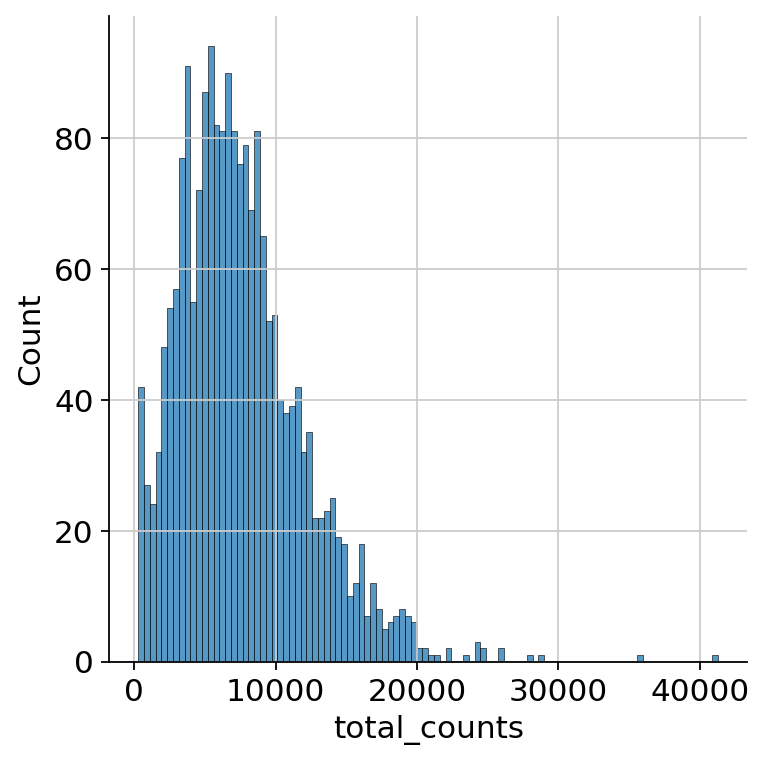

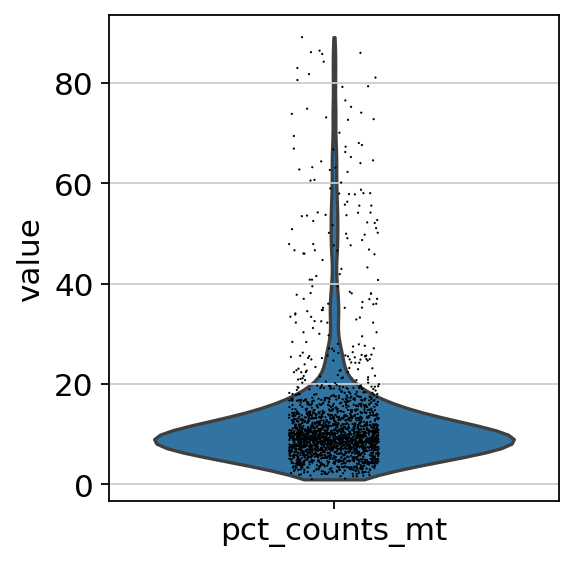

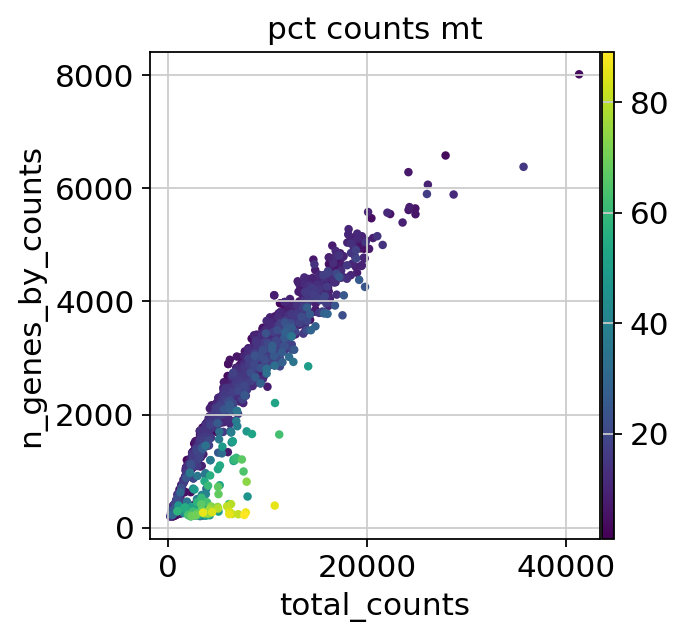

In [100]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [101]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [102]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

False    1834
True      216
Name: outlier, dtype: int64

In [103]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) 
adata.obs.mt_outlier.value_counts()

False    1804
True      246
Name: mt_outlier, dtype: int64

In [104]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 2050
Number of cells after filtering of low quality cells: 1720


In [105]:
data_mat = adata.X.T

In [106]:
# Run doublet detection
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~1500 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 97 cells excluded from training.
iter=1, 84 cells excluded from training.
iter=2, 80 cells excluded from training.
Threshold found:0.485
79 (4.6%) doublets called


In [107]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

singlet    1641
doublet      79
Name: scDblFinder_class, dtype: int64

In [108]:
adata.write('/mnt/sdb/qdang/singlecell/human/naive/epi_smits/quality_control.h5ad')

# Perform quality control of the scRNA-seq datasets (GSE216019). The dataset contains various individual samples and we provide representative code to pre-process one sample. 

In [29]:
f1_apex = sc.read_10x_mtx(
    path="/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/",prefix='GSM6656067_BRC2252_F1_D8_apex_', cache=True
)
f1_apex

AnnData object with n_obs × n_vars = 7095 × 36601
    var: 'gene_ids', 'feature_types'

In [30]:
f1_apex.var_names_make_unique()
f1_apex

AnnData object with n_obs × n_vars = 7095 × 36601
    var: 'gene_ids', 'feature_types'

In [31]:
# mitochondrial genes
f1_apex.var["mt"] = f1_apex.var_names.str.startswith("MT-")
# ribosomal genes
f1_apex.var["ribo"] = f1_apex.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
f1_apex.var["hb"] = f1_apex.var_names.str.contains(("^HB[^(P)]"))

In [32]:
sc.pp.calculate_qc_metrics(
    f1_apex, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
f1_apex

AnnData object with n_obs × n_vars = 7095 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [33]:
f1_apex.obs.dtypes

n_genes_by_counts               int32
log1p_n_genes_by_counts       float64
total_counts                  float32
log1p_total_counts            float32
pct_counts_in_top_20_genes    float64
total_counts_mt               float32
log1p_total_counts_mt         float32
pct_counts_mt                 float32
total_counts_ribo             float32
log1p_total_counts_ribo       float32
pct_counts_ribo               float32
total_counts_hb               float32
log1p_total_counts_hb         float32
pct_counts_hb                 float32
dtype: object

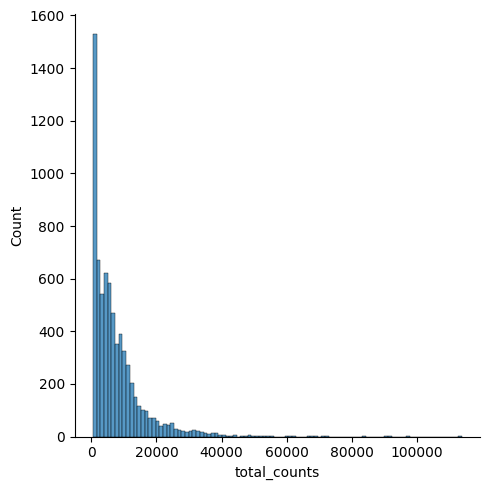

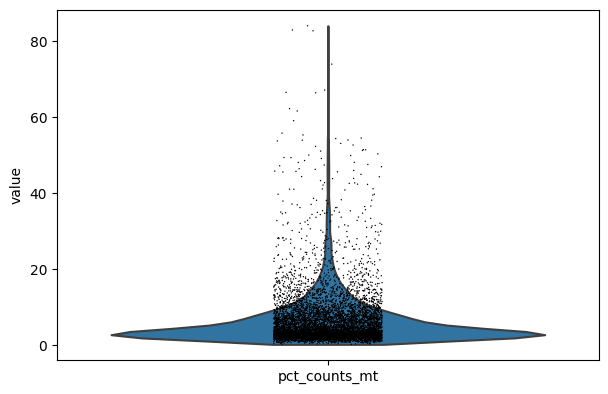

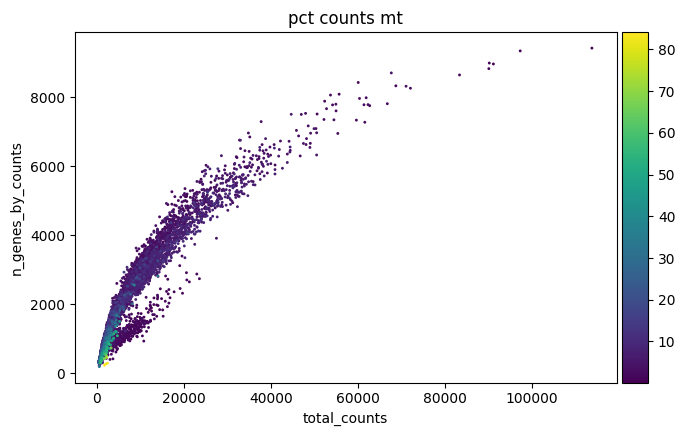

In [9]:
p1 = sns.displot(f1_apex.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(f1_apex, "pct_counts_mt")
p3 = sc.pl.scatter(f1_apex, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [34]:
def is_outlier(f1_apex, metric: str, nmads: int):
    M = f1_apex.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [38]:
f1_apex.obs["outlier"] = (
    is_outlier(f1_apex, "log1p_total_counts", 5)
    | is_outlier(f1_apex, "log1p_n_genes_by_counts", 5)
    | is_outlier(f1_apex, "pct_counts_in_top_20_genes", 5)
)
f1_apex.obs.outlier.value_counts()

False    5964
True     1131
Name: outlier, dtype: int64

In [39]:
f1_apex.obs["mt_outlier"] = is_outlier(f1_apex, "pct_counts_mt", 5) 
f1_apex.obs.mt_outlier.value_counts()

False    6478
True      617
Name: mt_outlier, dtype: int64

In [40]:
print(f"Total number of cells: {f1_apex.n_obs}")
f1_apex = f1_apex[(~f1_apex.obs.outlier) & (~f1_apex.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {f1_apex.n_obs}")

Total number of cells: 7095
Number of cells after filtering of low quality cells: 5620


In [56]:
data_mat = f1_apex.X.T

In [57]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~4496 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 801 cells excluded from training.
iter=1, 821 cells excluded from training.
iter=2, 840 cells excluded from training.
Threshold found:0.495
540 (9.6%) doublets called


In [58]:
f1_apex.obs["scDblFinder_score"] = doublet_score
f1_apex.obs["scDblFinder_class"] = doublet_class
f1_apex.obs.scDblFinder_class.value_counts()

singlet    5080
doublet     540
Name: scDblFinder_class, dtype: int64

# Analyze the next sample

In [60]:
f2_apex = sc.read_10x_mtx(
    path="/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/",prefix='GSM6656069_BRC2262_F2_B1_apex_', cache=True
)
f2_apex

AnnData object with n_obs × n_vars = 5727 × 36601
    var: 'gene_ids', 'feature_types'

In [61]:
f2_apex.var_names_make_unique()
f2_apex

AnnData object with n_obs × n_vars = 5727 × 36601
    var: 'gene_ids', 'feature_types'

In [62]:
# mitochondrial genes
f2_apex.var["mt"] = f2_apex.var_names.str.startswith("MT-")
# ribosomal genes
f2_apex.var["ribo"] = f2_apex.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
f2_apex.var["hb"] = f2_apex.var_names.str.contains(("^HB[^(P)]"))

In [63]:
sc.pp.calculate_qc_metrics(
    f2_apex, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
f2_apex

AnnData object with n_obs × n_vars = 5727 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

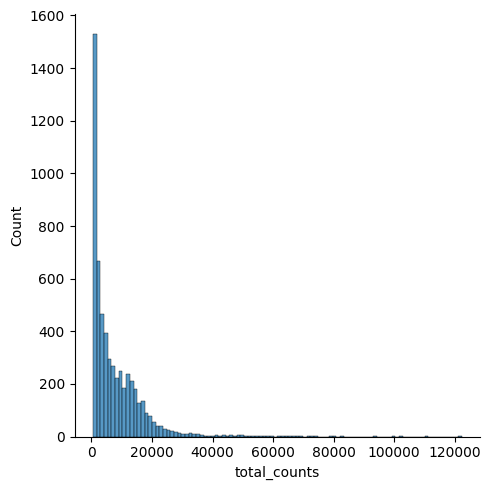

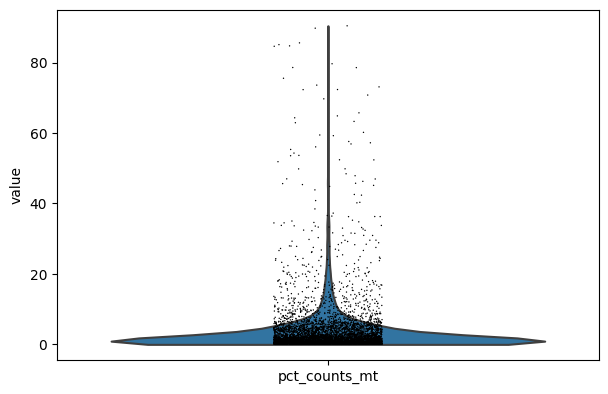

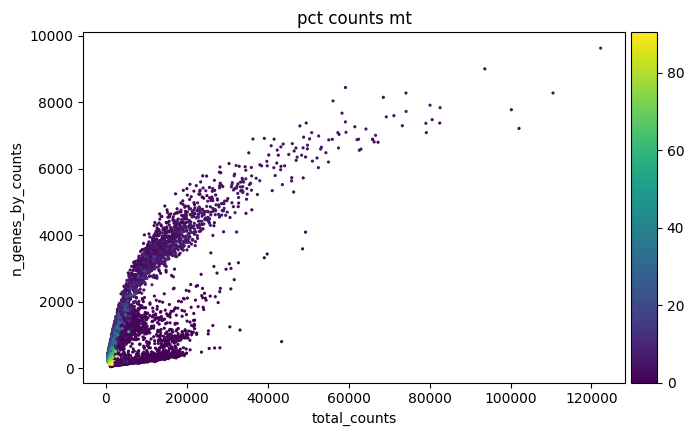

In [7]:
p1 = sns.displot(f2_apex.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(f2_apex, "pct_counts_mt")
p3 = sc.pl.scatter(f2_apex, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [64]:
def is_outlier(f2_apex, metric: str, nmads: int):
    M = f2_apex.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [65]:
f2_apex.obs["outlier"] = (
    is_outlier(f2_apex, "log1p_total_counts", 5)
    | is_outlier(f2_apex, "log1p_n_genes_by_counts", 5)
    | is_outlier(f2_apex, "pct_counts_in_top_20_genes", 5)
)
f2_apex.obs.outlier.value_counts()

False    4691
True     1036
Name: outlier, dtype: int64

In [66]:
f2_apex.obs["mt_outlier"] = is_outlier(f2_apex, "pct_counts_mt", 5) 
f2_apex.obs.mt_outlier.value_counts()

False    5117
True      610
Name: mt_outlier, dtype: int64

In [67]:
print(f"Total number of cells: {f2_apex.n_obs}")
f2_apex = f2_apex[(~f2_apex.obs.outlier) & (~f2_apex.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {f2_apex.n_obs}")

Total number of cells: 5727
Number of cells after filtering of low quality cells: 4084


In [77]:
print(f"Total number of genes: {f2_apex.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(f2_apex, min_cells=20)
print(f"Number of genes after cell filter: {f2_apex.n_vars}")

Total number of genes: 36601
Number of genes after cell filter: 16169


In [78]:
data_mat = f2_apex.X.T

In [79]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~3268 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 812 cells excluded from training.
iter=1, 819 cells excluded from training.
iter=2, 813 cells excluded from training.
Threshold found:0.471
277 (6.8%) doublets called


In [80]:
f2_apex.obs["scDblFinder_score"] = doublet_score
f2_apex.obs["scDblFinder_class"] = doublet_class
f2_apex.obs.scDblFinder_class.value_counts()

singlet    3807
doublet     277
Name: scDblFinder_class, dtype: int64

## Next sample

In [90]:
f3_apex = sc.read_10x_mtx(
    path="/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/",prefix='GSM6656071_BRC2251_F3_G4_apex_', cache=True
)
f3_apex

AnnData object with n_obs × n_vars = 3585 × 36601
    var: 'gene_ids', 'feature_types'

In [91]:
f3_apex.var_names_make_unique()
f3_apex

AnnData object with n_obs × n_vars = 3585 × 36601
    var: 'gene_ids', 'feature_types'

In [92]:
# mitochondrial genes
f3_apex.var["mt"] = f3_apex.var_names.str.startswith("MT-")
# ribosomal genes
f3_apex.var["ribo"] = f3_apex.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
f3_apex.var["hb"] = f3_apex.var_names.str.contains(("^HB[^(P)]"))

In [93]:
sc.pp.calculate_qc_metrics(
    f3_apex, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
f3_apex

AnnData object with n_obs × n_vars = 3585 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

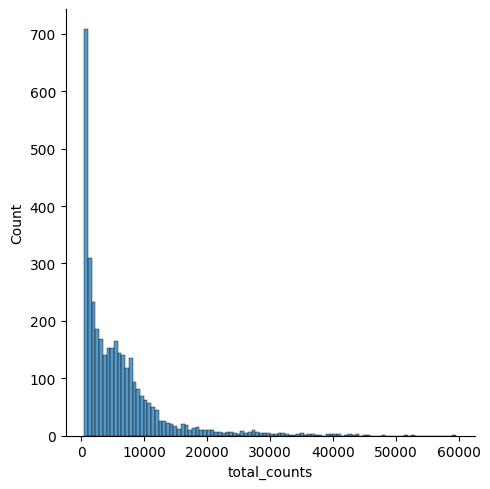

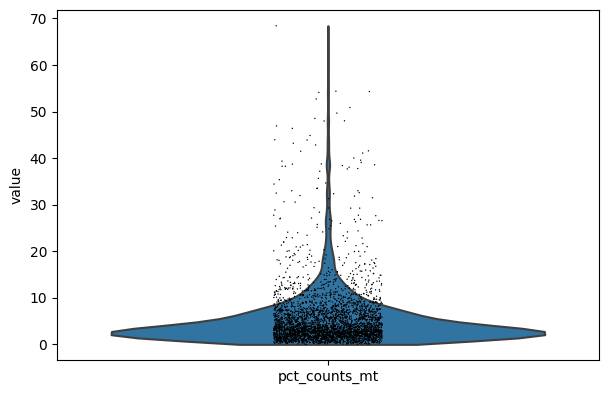

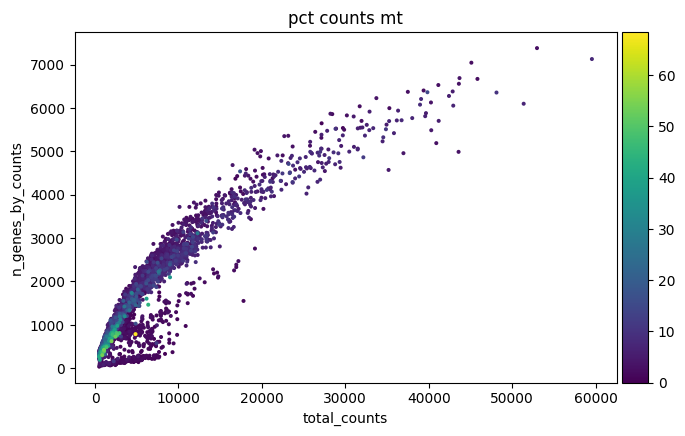

In [94]:
p1 = sns.displot(f3_apex.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(f3_apex, "pct_counts_mt")
p3 = sc.pl.scatter(f3_apex, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [95]:
def is_outlier(f3_apex, metric: str, nmads: int):
    M = f3_apex.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [96]:
f3_apex.obs["outlier"] = (
    is_outlier(f3_apex, "log1p_total_counts", 5)
    | is_outlier(f3_apex, "log1p_n_genes_by_counts", 5)
    | is_outlier(f3_apex, "pct_counts_in_top_20_genes", 5)
)
f3_apex.obs.outlier.value_counts()

False    2956
True      629
Name: outlier, dtype: int64

In [97]:
f3_apex.obs["mt_outlier"] = is_outlier(f3_apex, "pct_counts_mt", 5) 
f3_apex.obs.mt_outlier.value_counts()

False    3349
True      236
Name: mt_outlier, dtype: int64

In [98]:
print(f"Total number of cells: {f3_apex.n_obs}")
f3_apex = f3_apex[(~f3_apex.obs.outlier) & (~f3_apex.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {f3_apex.n_obs}")

Total number of cells: 3585
Number of cells after filtering of low quality cells: 2771


In [108]:
print(f"Total number of genes: {f3_apex.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(f3_apex, min_cells=20)
print(f"Number of genes after cell filter: {f3_apex.n_vars}")

Total number of genes: 36601
Number of genes after cell filter: 14247


In [ ]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

In [109]:
data_mat = f3_apex.X.T

In [110]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~2217 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 586 cells excluded from training.
iter=1, 571 cells excluded from training.
iter=2, 539 cells excluded from training.
Threshold found:0.479
152 (5.5%) doublets called


In [111]:
f3_apex.obs["scDblFinder_score"] = doublet_score
f3_apex.obs["scDblFinder_class"] = doublet_class
f3_apex.obs.scDblFinder_class.value_counts()

singlet    2619
doublet     152
Name: scDblFinder_class, dtype: int64

In [112]:
f3_apex.write("/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/f3_apex_quality_control.h5ad")

## Next sample

In [11]:
f4_apex = sc.read_10x_mtx(
    path="/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/",prefix='GSM6656074_BRC2263_F4_G7_apex_', cache=True
)
f4_apex

AnnData object with n_obs × n_vars = 2831 × 36601
    var: 'gene_ids', 'feature_types'

In [12]:
f4_apex.var_names_make_unique()
f4_apex

AnnData object with n_obs × n_vars = 2831 × 36601
    var: 'gene_ids', 'feature_types'

In [13]:
# mitochondrial genes
f4_apex.var["mt"] = f4_apex.var_names.str.startswith("MT-")
# ribosomal genes
f4_apex.var["ribo"] = f4_apex.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
f4_apex.var["hb"] = f4_apex.var_names.str.contains(("^HB[^(P)]"))

In [14]:
sc.pp.calculate_qc_metrics(
    f4_apex, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
f4_apex

AnnData object with n_obs × n_vars = 2831 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

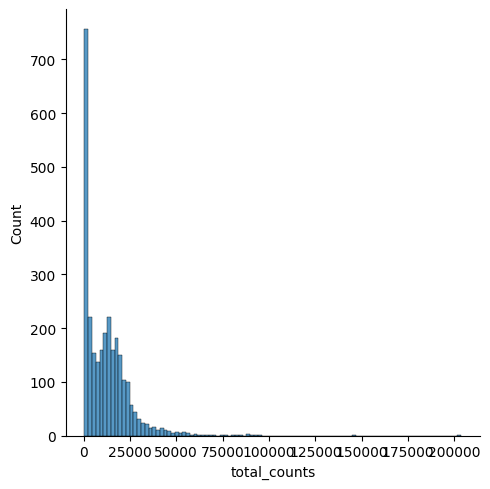

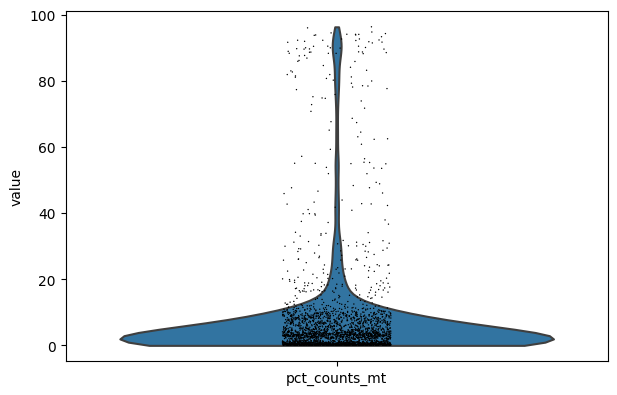

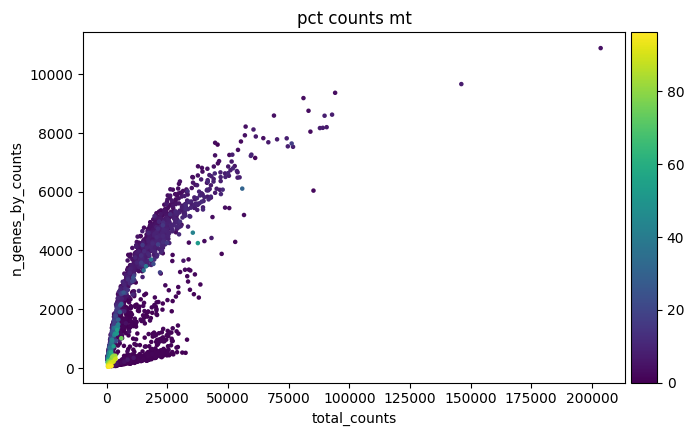

In [6]:
p1 = sns.displot(f4_apex.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(f4_apex, "pct_counts_mt")
p3 = sc.pl.scatter(f4_apex, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [15]:
def is_outlier(f4_apex, metric: str, nmads: int):
    M = f4_apex.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [16]:
f4_apex.obs["outlier"] = (
    is_outlier(f4_apex, "log1p_total_counts", 5)
    | is_outlier(f4_apex, "log1p_n_genes_by_counts", 5)
    | is_outlier(f4_apex, "pct_counts_in_top_20_genes", 5)
)
f4_apex.obs.outlier.value_counts()

False    2034
True      797
Name: outlier, dtype: int64

In [17]:
f4_apex.obs["mt_outlier"] = is_outlier(f4_apex, "pct_counts_mt", 5) 
f4_apex.obs.mt_outlier.value_counts()

False    2586
True      245
Name: mt_outlier, dtype: int64

In [18]:
print(f"Total number of cells: {f4_apex.n_obs}")
f4_apex = f4_apex[(~f4_apex.obs.outlier) & (~f4_apex.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {f4_apex.n_obs}")

Total number of cells: 2831
Number of cells after filtering of low quality cells: 1888


In [32]:
print(f"Total number of genes: {f4_apex.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(f4_apex, min_cells=20)
print(f"Number of genes after cell filter: {f4_apex.n_vars}")

Total number of genes: 36601
Number of genes after cell filter: 15467


In [35]:
data_mat = f4_apex.X.T

In [36]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~1511 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 473 cells excluded from training.
iter=1, 437 cells excluded from training.
iter=2, 373 cells excluded from training.
Threshold found:0.498
81 (4.3%) doublets called


In [37]:
f4_apex.obs["scDblFinder_score"] = doublet_score
f4_apex.obs["scDblFinder_class"] = doublet_class
f4_apex.obs.scDblFinder_class.value_counts()

singlet    1807
doublet      81
Name: scDblFinder_class, dtype: int64

In [38]:
f4_apex.write("/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/f4_apex_quality_control.h5ad")

## Next sample

In [2]:
f6_apex = sc.read_10x_mtx(
    path="/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/",prefix='GSM6656076_BRC2256_F6_F8_apex_', cache=True
)
f6_apex

AnnData object with n_obs × n_vars = 3331 × 36601
    var: 'gene_ids', 'feature_types'

In [3]:
f6_apex.var_names_make_unique()
f6_apex

AnnData object with n_obs × n_vars = 3331 × 36601
    var: 'gene_ids', 'feature_types'

In [4]:
# mitochondrial genes
f6_apex.var["mt"] = f6_apex.var_names.str.startswith("MT-")
# ribosomal genes
f6_apex.var["ribo"] = f6_apex.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
f6_apex.var["hb"] = f6_apex.var_names.str.contains(("^HB[^(P)]"))

In [5]:
sc.pp.calculate_qc_metrics(
    f6_apex, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
f6_apex

AnnData object with n_obs × n_vars = 3331 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

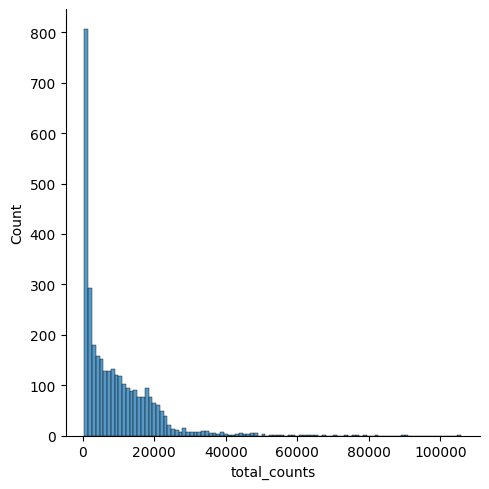

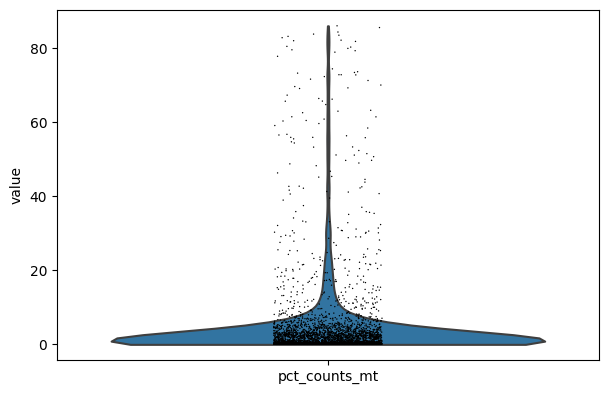

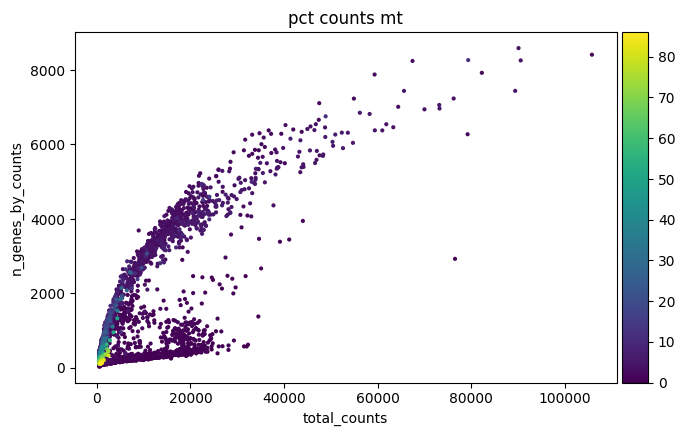

In [6]:
p1 = sns.displot(f6_apex.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(f6_apex, "pct_counts_mt")
p3 = sc.pl.scatter(f6_apex, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [7]:
def is_outlier(f6_apex, metric: str, nmads: int):
    M = f6_apex.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [8]:
f6_apex.obs["outlier"] = (
    is_outlier(f6_apex, "log1p_total_counts", 5)
    | is_outlier(f6_apex, "log1p_n_genes_by_counts", 5)
    | is_outlier(f6_apex, "pct_counts_in_top_20_genes", 5)
)
f6_apex.obs.outlier.value_counts()

False    3331
Name: outlier, dtype: int64

In [9]:
f6_apex.obs["mt_outlier"] = is_outlier(f6_apex, "pct_counts_mt", 5) 
f6_apex.obs.mt_outlier.value_counts()

False    2906
True      425
Name: mt_outlier, dtype: int64

In [10]:
print(f"Total number of cells: {f6_apex.n_obs}")
f6_apex = f6_apex[(~f6_apex.obs.outlier) & (~f6_apex.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {f6_apex.n_obs}")

Total number of cells: 3331
Number of cells after filtering of low quality cells: 2906


In [23]:
print(f"Total number of genes: {f6_apex.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(f6_apex, min_cells=20)
print(f"Number of genes after cell filter: {f6_apex.n_vars}")

Total number of genes: 36601
Number of genes after cell filter: 14129


In [25]:
data_mat = f6_apex.X.T

In [26]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~2325 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 447 cells excluded from training.
iter=1, 415 cells excluded from training.
iter=2, 392 cells excluded from training.
Threshold found:0.405
151 (5.2%) doublets called


In [27]:
f6_apex.obs["scDblFinder_score"] = doublet_score
f6_apex.obs["scDblFinder_class"] = doublet_class
f6_apex.obs.scDblFinder_class.value_counts()

singlet    2755
doublet     151
Name: scDblFinder_class, dtype: int64

In [28]:
f6_apex.write("/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/f6_apex_quality_control.h5ad")

# Continue

In [29]:
f7_apex = sc.read_10x_mtx(
    path="/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/",prefix='GSM6656079_BRC2260_F7_F2_apex_', cache=True
)
f7_apex

AnnData object with n_obs × n_vars = 13584 × 36601
    var: 'gene_ids', 'feature_types'

In [30]:
f7_apex.var_names_make_unique()
f7_apex

AnnData object with n_obs × n_vars = 13584 × 36601
    var: 'gene_ids', 'feature_types'

In [31]:
# mitochondrial genes
f7_apex.var["mt"] = f7_apex.var_names.str.startswith("MT-")
# ribosomal genes
f7_apex.var["ribo"] = f7_apex.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
f7_apex.var["hb"] = f7_apex.var_names.str.contains(("^HB[^(P)]"))

In [32]:
sc.pp.calculate_qc_metrics(
    f7_apex, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
f7_apex

AnnData object with n_obs × n_vars = 13584 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

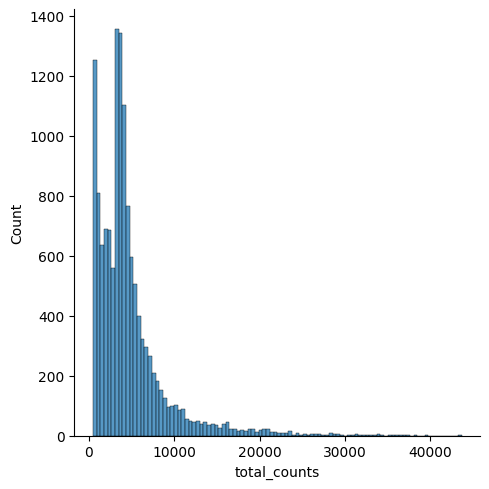

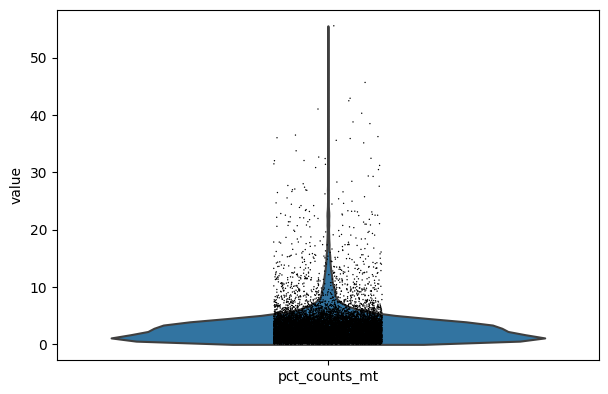

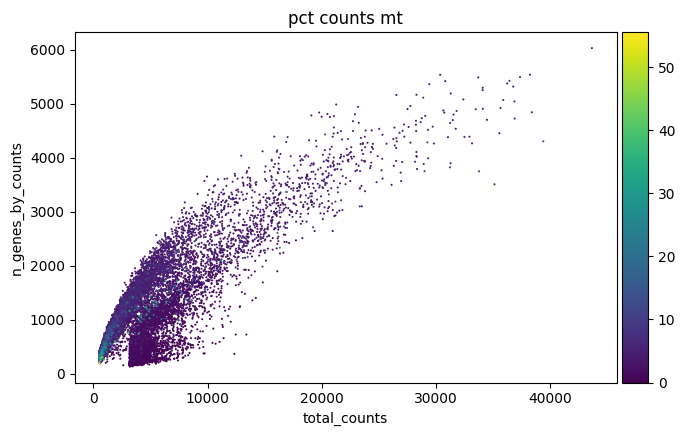

In [33]:
p1 = sns.displot(f7_apex.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(f7_apex, "pct_counts_mt")
p3 = sc.pl.scatter(f7_apex, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [34]:
def is_outlier(f7_apex, metric: str, nmads: int):
    M = f7_apex.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [35]:
f7_apex.obs["outlier"] = (
    is_outlier(f7_apex, "log1p_total_counts", 5)
    | is_outlier(f7_apex, "log1p_n_genes_by_counts", 5)
    | is_outlier(f7_apex, "pct_counts_in_top_20_genes", 5)
)
f7_apex.obs.outlier.value_counts()

False    13571
True        13
Name: outlier, dtype: int64

In [41]:
f7_apex.obs["mt_outlier"] = is_outlier(f7_apex, "pct_counts_mt", 3) | (
    f7_apex.obs["pct_counts_mt"] > 8
)
f7_apex.obs.mt_outlier.value_counts()

False    12679
True       905
Name: mt_outlier, dtype: int64

In [42]:
print(f"Total number of cells: {f7_apex.n_obs}")
f7_apex = f7_apex[(~f7_apex.obs.outlier) & (~f7_apex.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {f7_apex.n_obs}")

Total number of cells: 13584
Number of cells after filtering of low quality cells: 12668


In [52]:
print(f"Total number of genes: {f7_apex.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(f7_apex, min_cells=20)
print(f"Number of genes after cell filter: {f7_apex.n_vars}")

Total number of genes: 36601
Number of genes after cell filter: 16674


In [53]:
data_mat = f7_apex.X.T

In [54]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~10135 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 2270 cells excluded from training.
iter=1, 2208 cells excluded from training.
iter=2, 2205 cells excluded from training.
Threshold found:0.445
1666 (13.2%) doublets called


In [55]:
f7_apex.obs["scDblFinder_score"] = doublet_score
f7_apex.obs["scDblFinder_class"] = doublet_class
f7_apex.obs.scDblFinder_class.value_counts()

singlet    11002
doublet     1666
Name: scDblFinder_class, dtype: int64

In [56]:
f7_apex.write("/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/f7_apex_quality_control.h5ad")

## The above samples have been from the fetal heart apex. We further analysed their cardiac base samples to acquire more epicardial cells

In [2]:
adata = sc.read_10x_mtx(
    path="/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/",prefix='GSM6656072_BRC2251_F3_F4_base_', cache=True
)
adata

AnnData object with n_obs × n_vars = 10386 × 36601
    var: 'gene_ids', 'feature_types'

In [3]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 10386 × 36601
    var: 'gene_ids', 'feature_types'

In [4]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [5]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 10386 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

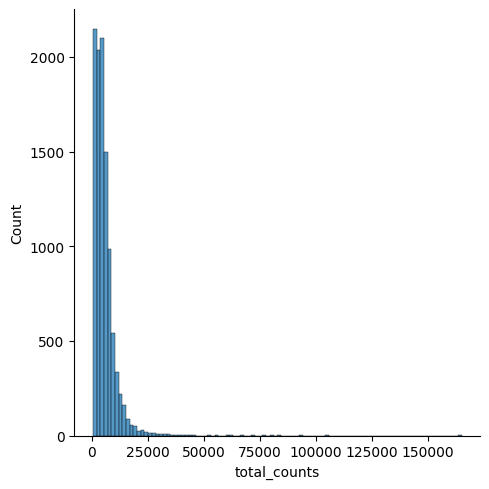

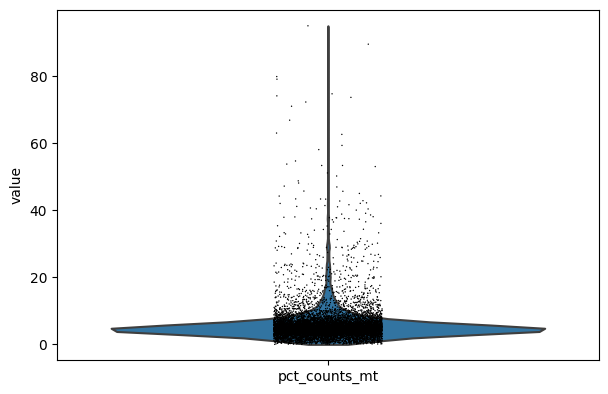

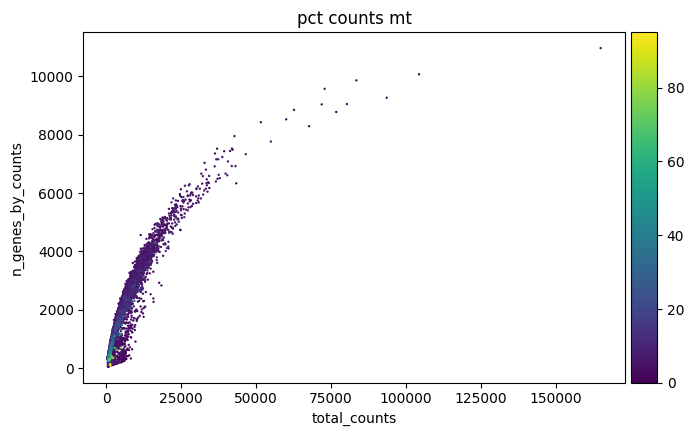

In [6]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [7]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [8]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

False    8959
True     1427
Name: outlier, dtype: int64

In [16]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 5) | (
    adata.obs["pct_counts_mt"] > 15
)
adata.obs.mt_outlier.value_counts()

False    9774
True      612
Name: mt_outlier, dtype: int64

In [17]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 10386
Number of cells after filtering of low quality cells: 8622


In [29]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 36601
Number of genes after cell filter: 17979


In [31]:
data_mat = adata.X.T

In [32]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~6898 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1524 cells excluded from training.
iter=1, 1517 cells excluded from training.
iter=2, 1500 cells excluded from training.
Threshold found:0.454
932 (10.8%) doublets called


In [33]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

singlet    7690
doublet     932
Name: scDblFinder_class, dtype: int64

In [34]:
adata.write("/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/f3_base_quality_control.h5ad")

# Analyze F6 base

In [2]:
adata = sc.read_10x_mtx(
    path="/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/",prefix='GSM6656077_BRC2256_F6_E8_base_', cache=True
)
adata

AnnData object with n_obs × n_vars = 14363 × 36601
    var: 'gene_ids', 'feature_types'

In [3]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 14363 × 36601
    var: 'gene_ids', 'feature_types'

In [4]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [5]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 14363 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

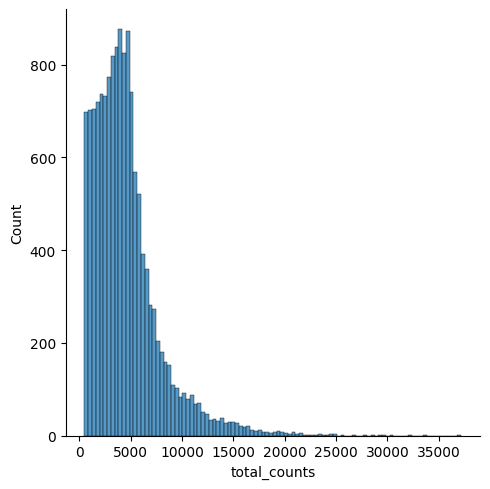

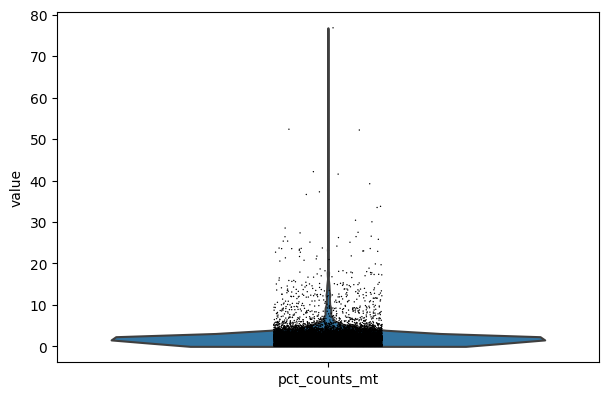

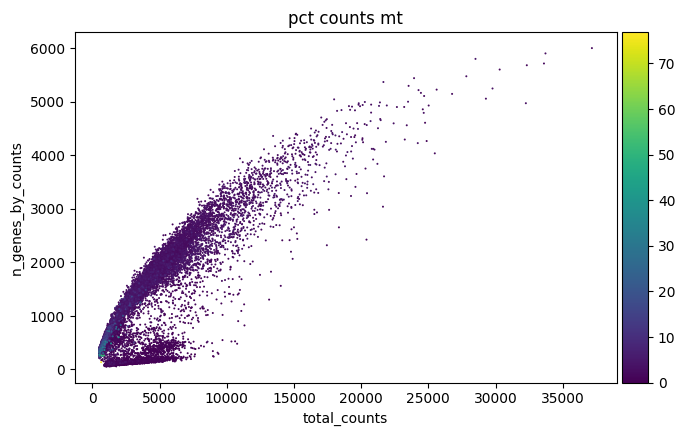

In [6]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [7]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [8]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

False    10362
True      4001
Name: outlier, dtype: int64

In [10]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 5) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

False    13937
True       426
Name: mt_outlier, dtype: int64

In [11]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 14363
Number of cells after filtering of low quality cells: 9968


In [23]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 36601
Number of genes after cell filter: 17513


In [25]:
data_mat = adata.X.T

In [26]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~7975 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1665 cells excluded from training.
iter=1, 1622 cells excluded from training.
iter=2, 1539 cells excluded from training.
Threshold found:0.437
867 (8.7%) doublets called


In [27]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

singlet    9101
doublet     867
Name: scDblFinder_class, dtype: int64

In [28]:
adata.write("/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/f6_base_quality_control.h5ad")

# Next sample, F7 base

In [3]:
adata = sc.read_10x_mtx(
    path="/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/",prefix='GSM6656080_BRC2260_F7_E2_base_', cache=True
)
adata

AnnData object with n_obs × n_vars = 12128 × 36601
    var: 'gene_ids', 'feature_types'

In [4]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 12128 × 36601
    var: 'gene_ids', 'feature_types'

In [5]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [6]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 12128 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

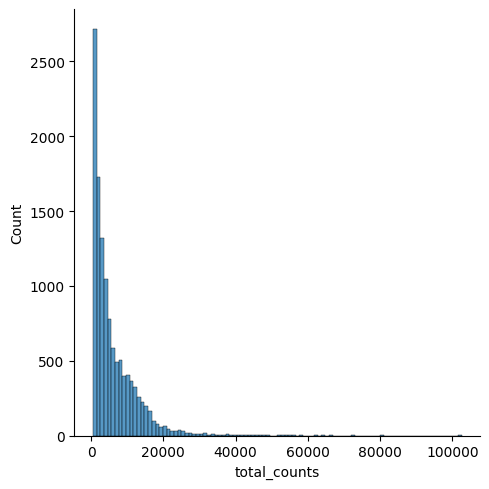

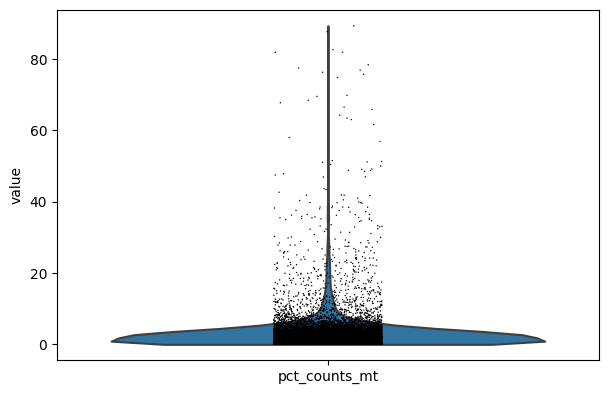

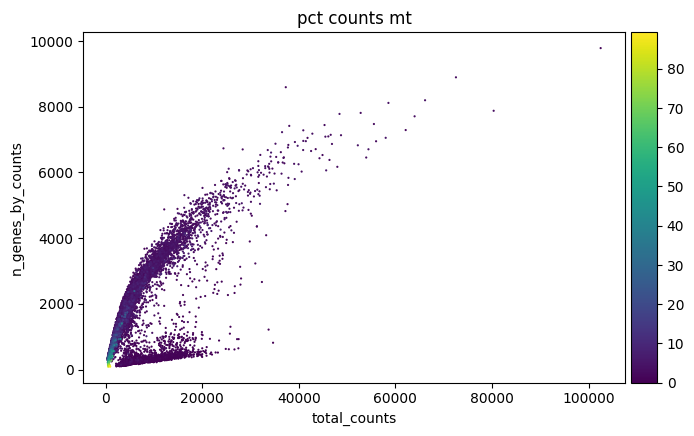

In [7]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [8]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [9]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

False    9310
True     2818
Name: outlier, dtype: int64

In [12]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 5) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

False    11345
True       783
Name: mt_outlier, dtype: int64

In [13]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 12128
Number of cells after filtering of low quality cells: 8541


In [25]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 36601
Number of genes after cell filter: 18102


In [27]:
data_mat = adata.X.T

In [28]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~6833 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1411 cells excluded from training.
iter=1, 1500 cells excluded from training.
iter=2, 1471 cells excluded from training.
Threshold found:0.491
869 (10.2%) doublets called


In [29]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

singlet    7672
doublet     869
Name: scDblFinder_class, dtype: int64

In [30]:
adata.write("/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/f7_base_quality_control.h5ad")

# Last sample, C8 base

In [3]:
adata = sc.read_10x_mtx(
    path="/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/",prefix='GSM6656068_BRC2252_F1_C8_base_', cache=True
)
adata

AnnData object with n_obs × n_vars = 5146 × 36601
    var: 'gene_ids', 'feature_types'

In [4]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [5]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 5146 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

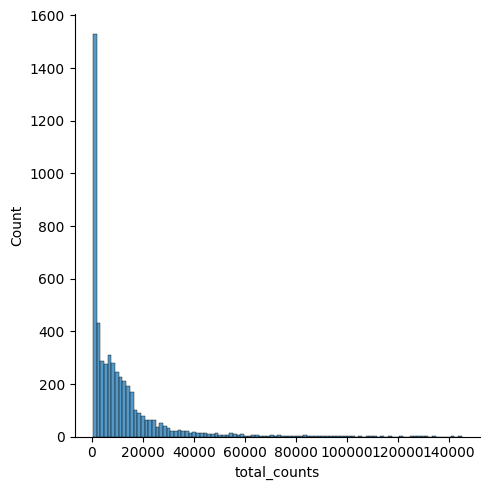

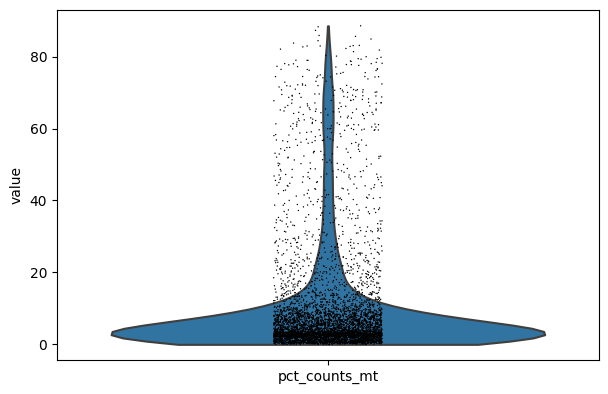

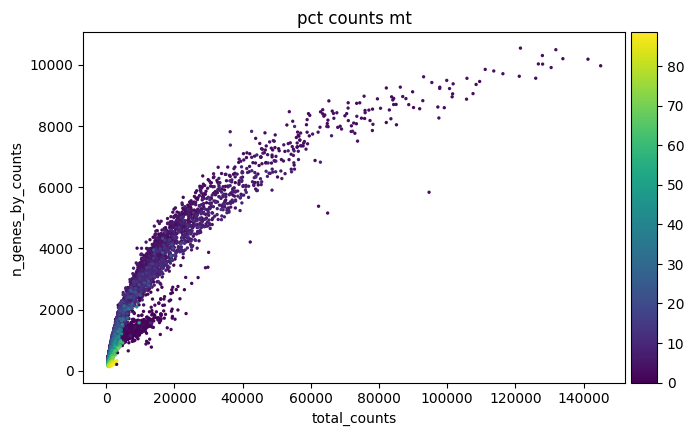

In [6]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [7]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [8]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

False    4321
True      825
Name: outlier, dtype: int64

In [11]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 5)
adata.obs.mt_outlier.value_counts()

False    4409
True      737
Name: mt_outlier, dtype: int64

In [12]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 5146
Number of cells after filtering of low quality cells: 3915


In [24]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 36601
Number of genes after cell filter: 17440


In [26]:
data_mat = adata.X.T

In [27]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~3132 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 482 cells excluded from training.
iter=1, 528 cells excluded from training.
iter=2, 524 cells excluded from training.
Threshold found:0.548
285 (7.3%) doublets called


In [28]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

singlet    3630
doublet     285
Name: scDblFinder_class, dtype: int64

In [29]:
adata.write("/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/f1_base_quality_control.h5ad")

# Analyze fetal data from: https://www.sciencedirect.com/science/article/pii/S009286742201503

In [2]:
adata = sc.read('/mnt/sdb/qdang/singlecell/human/naive/cardiogenesis_kundaje/object.h5ad')
adata

AnnData object with n_obs × n_vars = 17617 × 68120
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Sample', 'read_depth', 'new_manual_annotation', 'time', 'EXPT'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'

In [16]:
adata.layers['counts'] = adata.X.copy()
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)
adata.X = adata.layers["log1p_norm"]

/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


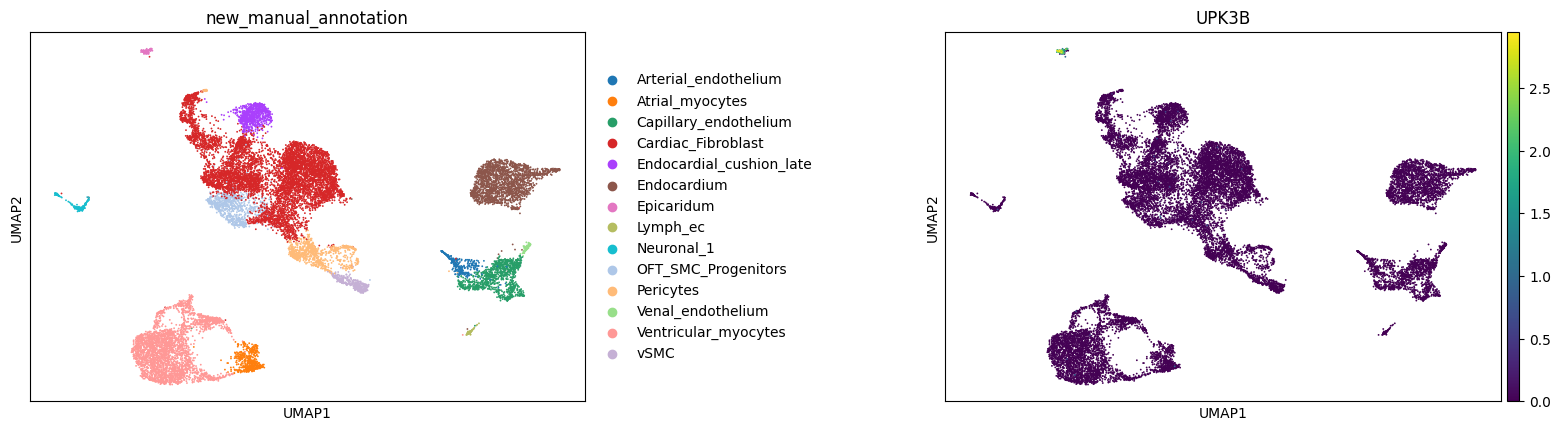

In [21]:
sc.pl.umap(adata, color=['new_manual_annotation','UPK3B'], wspace=0.5, use_raw=False)

In [13]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 17617 × 27957
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Sample', 'read_depth', 'new_manual_annotation', 'time', 'EXPT', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'new_manual_annotation_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'

In [20]:
adata = adatas2

In [21]:
data_mat = adata.X.T

In [25]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~14094 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1789 cells excluded from training.
iter=1, 1697 cells excluded from training.
iter=2, 1679 cells excluded from training.
Threshold found:0.002
1645 (9.3%) doublets called


In [26]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

singlet    15972
doublet     1645
Name: scDblFinder_class, dtype: int64

In [27]:
adata.write('/mnt/sdb/qdang/singlecell/human/naive/cardiogenesis_kundaje/processed.h5ad')

# Acquire scRNA-seq fetal heart data (GSE106118)

In [27]:
adata = sc.read_text('/mnt/sdb/qdang/singlecell/human/naive/PMID_30759401/GSE106118_UMI_count_merge.txt')

In [30]:
# Trabspose the data to ensure .var are gene names and .obs are cell names
adata = adata.transpose()
adata

AnnData object with n_obs × n_vars = 4948 × 24153

In [31]:
# Verify correct arrangment of .obs after transposing
adata.obs_names

Index(['HE5W_1_LA.1', 'HE5W_1_LA.2', 'HE5W_1_LA.3', 'HE5W_1_LA.4',
       'HE5W_1_LA.5', 'HE5W_1_LA.6', 'HE5W_1_LA.7', 'HE5W_1_LA.8',
       'HE5W_1_LA.9', 'HE5W_1_LA.10',
       ...
       'HE23W_2_RV.15', 'HE23W_2_RV.16', 'HE23W_2_RV.17', 'HE23W_2_RV.18',
       'HE23W_2_RV.19', 'HE23W_2_RV.20', 'HE23W_2_RV.21', 'HE23W_2_RV.22',
       'HE23W_2_RV.23', 'HE23W_2_RV.24'],
      dtype='object', length=4948)

In [32]:
# Import data annotation as a dataframe
import pandas as pd
anno = pd.read_csv('/mnt/sdb/qdang/singlecell/human/naive/PMID_30759401/PMID_30759401_metadata.csv', index_col=0)

In [54]:
# Some of the cells in the anndata object did not have any annotation. These could have been poor quality cells that were eventually filtered out. 
list2 = adata.obs_names.tolist()
list3 = anno.index.tolist()
inter = set(list3).intersection(list2)
len(inter)

4936

In [58]:
inter = list(inter)
anno2 = anno[anno.index.isin(inter)]
anno2

barcode      region   time
cell                                      
HE6W_1_LA.1    AACGTGAT          LA   PC6W
HE6W_1_LA.2    AAACATCG          LA   PC6W
HE6W_1_LA.3    ATGCCTAA          LA   PC6W
HE6W_1_LA.4    AGTGGTCA          LA   PC6W
HE6W_1_LA.5    ACCACTGT          LA   PC6W
...                 ...         ...    ...
HE23W_2_RV.20  TTCACGCA  2_LVRV_TPM  PC23W
HE23W_2_RV.21  AACTCACC  2_LVRV_TPM  PC23W
HE23W_2_RV.22  AAGAGATC  2_LVRV_TPM  PC23W
HE23W_2_RV.23  AAGGACAC  2_LVRV_TPM  PC23W
HE23W_2_RV.24  AATCCGTC  2_LVRV_TPM  PC23W

[4936 rows x 3 columns]

In [59]:
# Filter the anndata object for cell barcodes contained in the annotation dataframe
adata2 = adata[inter].copy()
adata2

AnnData object with n_obs × n_vars = 4936 × 24153

In [60]:
# Combine the annotation with the anndata object
adata.obs = anno2
adata

AnnData object with n_obs × n_vars = 4936 × 24153
    obs: 'barcode', 'region', 'time'

In [79]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [80]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

False    4452
True      484
Name: outlier, dtype: int64

In [81]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[~adata.obs.outlier].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 4936
Number of cells after filtering of low quality cells: 4452


In [83]:
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 4452 × 22538
    obs: 'barcode', 'region', 'time', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [85]:
data_mat = adata.X.T

In [86]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~3562 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 543 cells excluded from training.
iter=1, 584 cells excluded from training.
iter=2, 597 cells excluded from training.
Threshold found:0.61
376 (8.4%) doublets called


In [87]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

singlet    4076
doublet     376
Name: scDblFinder_class, dtype: int64

# Perform single-cell integration

In [2]:
# These are preprocessed data from GSE216019
f1_base = sc.read('/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/f1_base_quality_control.h5ad')
f2_apex = sc.read('/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/f2_apex_quality_control.h5ad')
f3_apex = sc.read('/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/f3_apex_quality_control.h5ad')
f3_base = sc.read('/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/f3_base_quality_control.h5ad')
f6_base = sc.read('/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/f6_base_quality_control.h5ad')
f7_base = sc.read('/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/f7_base_quality_control.h5ad')
f7_apex = sc.read('/mnt/sdb/qdang/singlecell/human/naive/PRJNA891720/f7_apex_quality_control.h5ad')

In [3]:
# Add annotation
f1_base.obs['time'] = 'PCW8'
f2_apex.obs['time'] = 'PCW8'
f3_apex.obs['time'] = 'PCW9'
f7_apex.obs['time'] = 'PCW11'
f3_base.obs['time'] = 'PCW9'
f6_base.obs['time'] = 'PCW10'
f7_base.obs['time'] = 'PCW11'
f1_base.obs['region'] = 'base'
f2_apex.obs['region'] = 'apex'
f3_apex.obs['region'] = 'apex'
f7_apex.obs['region'] = 'apex'
f3_base.obs['region'] = 'base'
f6_base.obs['region'] = 'base'
f7_base.obs['region'] = 'base'

In [5]:
# Concatenate the datasets
adatas1 = {"F1_Base": f1_base, "F2_Apex": f2_apex, "F3_Apex": f3_apex, "F7_Apex": f7_apex, "F3_Base": f3_base, "F6_Base": f6_base, "F7_Base": f7_base}
adatas1 = ad.concat(adatas1, label="Sample", join="outer")
adatas1.obs_names_make_unique()
adatas1

/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 50569 × 19903
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'time', 'region', 'Sample'
    layers: 'counts', 'soupX_counts'

In [4]:
# Load the data from https://www.sciencedirect.com/science/article/pii/S0092867422015033
adatas2 = sc.read('/mnt/sdb/qdang/singlecell/human/naive/cardiogenesis_kundaje/processed.h5ad')
del adatas2.obs['Sample']
adatas2

AnnData object with n_obs × n_vars = 17617 × 27957
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'read_depth', 'new_manual_annotation', 'time', 'EXPT', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'scDblFinder_score', 'scDblFinder_class'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'new_manual_annotation_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'
    layers: 'counts', 'log1p_norm'

In [5]:
adatas2.X = adatas2.layers['counts'].copy()

In [ ]:
# Load the data from GSE106118
from scipy import sparse
adatas3 = sc.read('/mnt/sdb/qdang/singlecell/human/naive/PMID_30759401/processed_filtered.h5ad')
sparse_X = sparse.csr_matrix(adatas3.X)
adatas3.X = sparse_X

In [12]:
adatas1

AnnData object with n_obs × n_vars = 50569 × 19903
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'time', 'region', 'Sample'
    layers: 'counts', 'soupX_counts'

In [13]:
adatas2

AnnData object with n_obs × n_vars = 17617 × 27957
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'read_depth', 'new_manual_annotation', 'time', 'EXPT', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'scDblFinder_score', 'scDblFinder_class'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'new_manual_annotation_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'
    layers: 'counts', 'log1p_norm'

In [14]:
adatas3

AnnData object with n_obs × n_vars = 4452 × 22538
    obs: 'barcode', 'region', 'time', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'scDblFinder_score', 'scDblFinder_class'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p_norm'
    obsp: 'connectivities', 'distances'

In [9]:
# Load the data from GSE213669
adatas4 = sc.read('/mnt/sdb/qdang/singlecell/human/naive/epi_smits/quality_control.h5ad')
adatas4

AnnData object with n_obs × n_vars = 1720 × 17123
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [ ]:
adatas4.layers['counts'] = adatas4.X.copy()
sparse_X = sparse.csr_matrix(adatas4.X)
adatas4.X = sparse_X

In [13]:
# Load the dataset from GSE213669
adatas5 = sc.read('/mnt/sdb/qdang/singlecell/PMID_37676760/concat_raw.h5ad')
adatas5.obs['region'] = 'apex'
del adatas5.layers['log1p_norm']
adatas5

AnnData object with n_obs × n_vars = 21940 × 24551
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'time'
    layers: 'counts', 'log1p_norm', 'soupX_counts'

In [18]:
# Concatenate all datasets
adatas = {"PMID_36938497_Sinha": adatas1, "PMID_36563664_Kundaje": adatas2, "PMID_30759401_Yan": adatas3, "PMID_37390825_Smits": adatas4,
         "PMID_37676760_Lien": adatas5}
adatas = ad.concat(adatas, label="Batch", join="outer")
adatas.obs_names_make_unique()
adatas

/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 96298 × 39102
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'time', 'region', 'Sample', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'read_depth', 'new_manual_annotation', 'EXPT', 'n_genes', 'barcode', 'Batch'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts', 'soupX_counts', 'log1p_norm'

In [19]:
adatas.obs_names_make_unique()

In [9]:
# Filter out cells with fewer than 200 genes and genes expressed in fewer than 3 cells
sc.pp.filter_cells(adatas, min_genes=200)
sc.pp.filter_genes(adatas, min_cells=3)
adatas

AnnData object with n_obs × n_vars = 95189 × 39077
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'time', 'region', 'Sample', 'percent.mt', 'EXPT', 'n_genes', 'barcode', 'Batch'
    var: 'n_cells'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts', 'log1p_norm', 'soupX_counts'

In [10]:
# Normalise and log1p transformation
scales_counts = sc.pp.normalize_total(adatas, target_sum=None, inplace=False)
adatas.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)
adatas.X = adatas.layers["log1p_norm"].copy()

In [13]:
# Perform HVG-aware batch selection
sc.pp.highly_variable_genes(
    adatas, n_top_genes=6000, flavor="cell_ranger", batch_key='Batch'
)
adatas.var

n_cells  highly_variable     means  dispersions  \
                 1720            False  0.820182     0.017702   
-1               1621            False  0.310224     0.062186   
-10                20            False  0.001312     0.141877   
-11                14            False  0.000734     0.095570   
-12                13            False  0.000895     0.141337   
...               ...              ...       ...          ...   
bP-21264C1.1        3            False  0.000019     0.113636   
bP-21264C1.2       48            False  0.000343     0.137980   
bP-2189O9.2        62            False  0.000464     0.142105   
bP-2189O9.3         5            False  0.000037     0.139670   
uc-338.14           9            False  0.000063     0.127276   

              dispersions_norm  highly_variable_nbatches  \
                     -0.554768                         0   
-1                   -0.191085                         0   
-10                   0.160868                         1   
-11                  -0.172709                         0   
-12                   0.168353                         1   
...                        ...                       ...   
bP-21264C1.1         -0.151634                         0   
bP-21264C1.2         -0.102279                         0   
bP-2189O9.2          -0.094710                         0   
bP-2189O9.3           0.049041                         0   
uc-338.14            -0.123212                         0   

              highly_variable_intersection  
                                     False  
-1                                   False  
-10                                  False  
-11                                  False  
-12                                  False  
...                                    ...  
bP-21264C1.1                         False  
bP-21264C1.2                         False  
bP-2189O9.2                          False  
bP-2189O9.3                          False  
uc-338.14                            False  

[39077 rows x 7 columns]

0    21733
1    10467
2     3557
3     1570
4     1041
5      709
Name: highly_variable_nbatches, dtype: int64

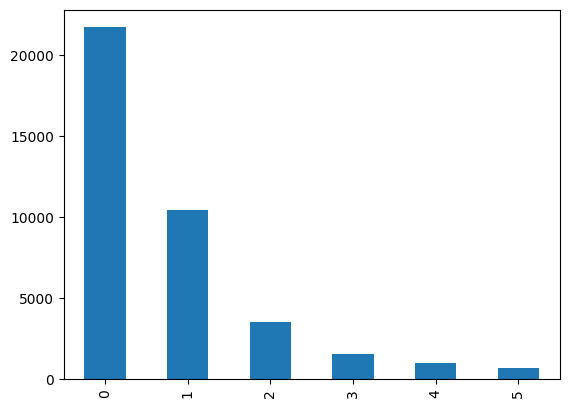

In [14]:
n_batches = adatas.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


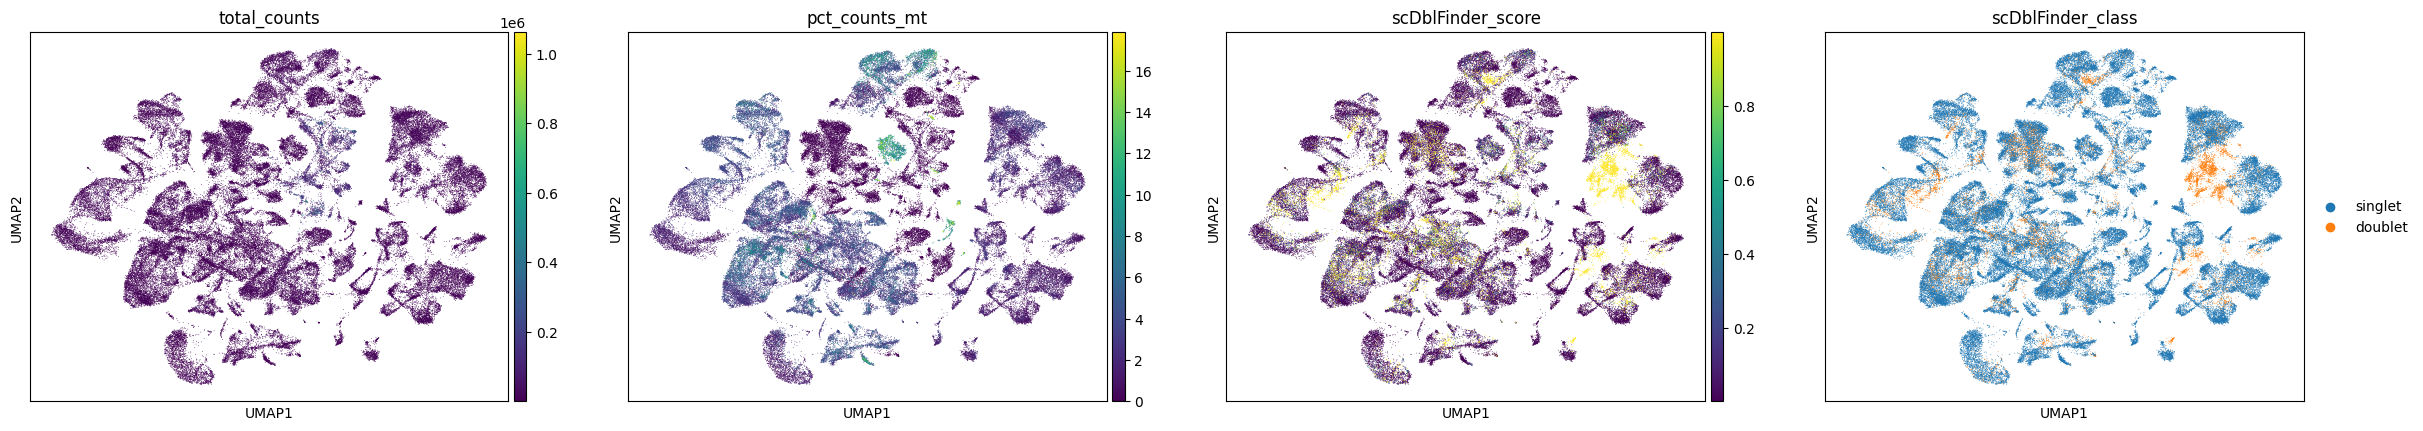

In [16]:
sc.pp.pca(adatas, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(adatas)
sc.tl.umap(adatas)
sc.pl.umap(
    adatas,
    color=["total_counts", "pct_counts_mt", "scDblFinder_score", "scDblFinder_class"],
)

/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


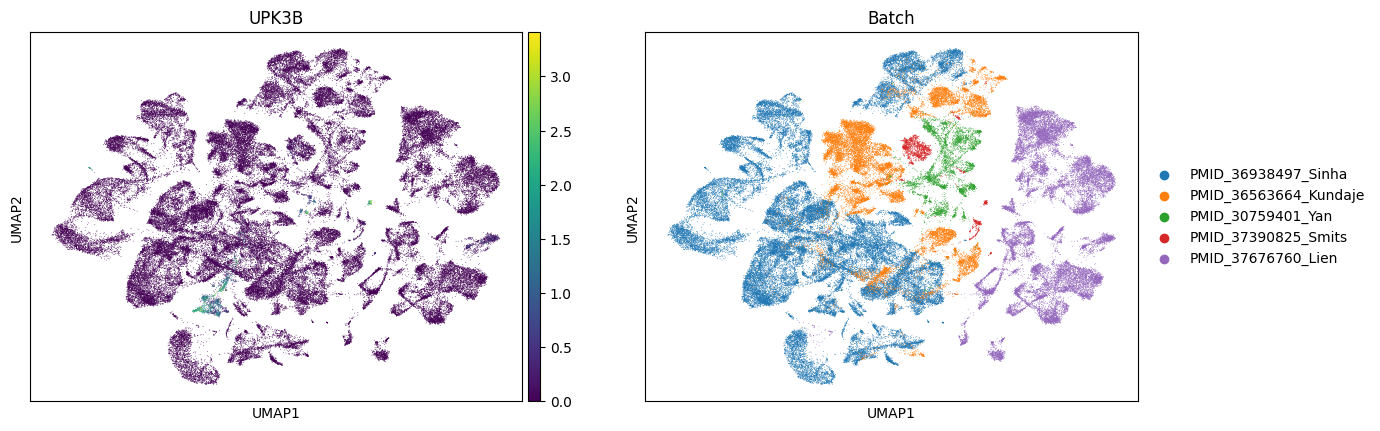

In [17]:
sc.pl.umap(
    adatas,
    color=["UPK3B","Batch"],
)

In [18]:
adatas.uns['Batch' + "_colors"] = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#36423f",
    "#93d62d"
]

/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


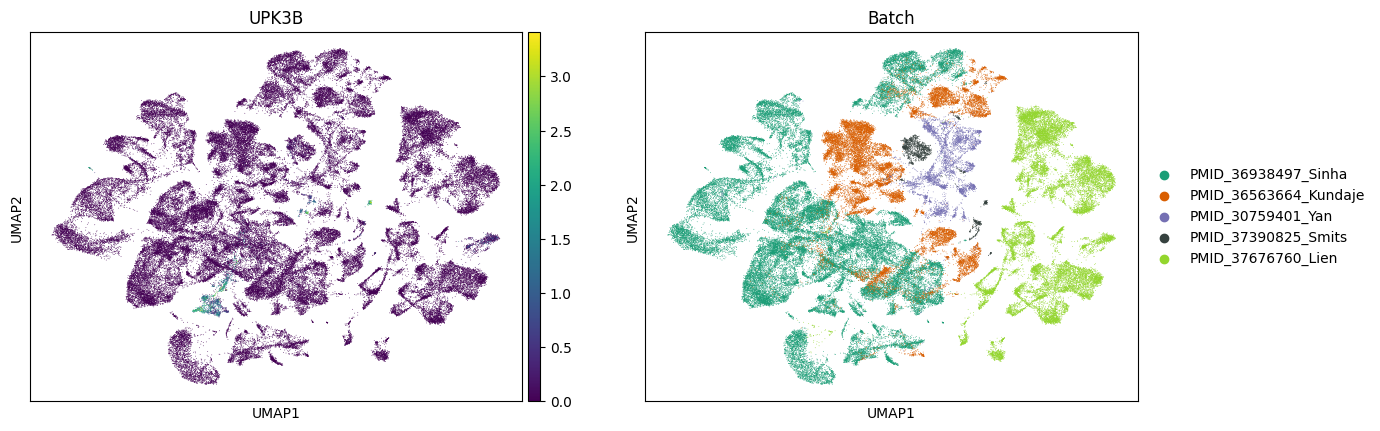

In [19]:
# We can observe batch driving biological heterogeneity in epicardial cells, necessitating integration
sc.pl.umap(
    adatas,
    color=["UPK3B","Batch"],
)

In [20]:
adatas.X = adatas.layers['counts'].copy()
adatas.raw = adatas
adata_hvg = adatas[:, adatas.var["highly_variable"]].copy()
adata_hvg

AnnData object with n_obs × n_vars = 95189 × 6000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'time', 'region', 'Sample', 'percent.mt', 'EXPT', 'n_genes', 'barcode', 'Batch'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'scDblFinder_class_colors', 'Batch_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p_norm', 'soupX_counts'
    obsp: 'distances', 'connectivities'

In [ ]:
adata_hvg.write("/mnt/sdb/qdang/singlecell/human/naive/fullgene_hvg_foetal_integrated.h5ad")